# 060 Introduction to Scikit Learn

> COM6018

*Copyright &copy; 2023, 2024 Jon Barker, University of Sheffield. All rights reserved*.


In this lab class, we will use the scikit-learn library to implement a k-nearest neighbour classifier and apply it to a simple classification problem. Before attempting this lab, make sure that you have read the corresponding tutorial notes [060_Introducing_Scikit_Learn](https://uos-com-6018.github.io/COM6018/materials/tutorials/060_Introducing_Scikit_Learn.html).


## Background 

The classification task that we will tackle in this lab concerns the passive detection of land mines. The data set is described in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/763/land+mines-1) and in the following publication,

- Yilmaz, C., Kahraman, H. T., & Söyler, S. (2018). *Passive mine detection and classification method based on hybrid model*. IEEE Access, 6, 47870-47888 [DOI:10.1109/ACCESS.2018.2866538](https://archive.ics.uci.edu/dataset/763/land+mines-1).

Landmines can be detected using a passive sensor similar to a metal detector. The detector is swept above the ground and produces a voltage signal output. If the value is high, then that indicates that there is possibly a mine present. This mine can then be carefully cleared. The problem is that there are other things that can cause a signal. Furthermore, the strength of the signal depends on the level of the sensor above the ground and the type of soil.

Data is provide for 338 detections some of which are landmines and some of which are not. For each sample, the following three measurements are provided:

- Voltage (V): The output voltage value from a magnetic sensor.
- High (H): The height of the sensor above the ground.
- Soil Type (S): A value that corresponds to the amount of moisture in the soil.

The output label that we wish to predict is one of 5 classes:

- 1: No Landmine 
- 2: Anti-Tank Mine
- 3: Anti-Personnel Mine
- 4: Booby-trapped Anti-Tank Mine
- 5: M14 Anti-Personnel Mine

There are a roughly equal number of samples for each class. 

The primary task is to distinguish between class 1 (i.e., no mine) and the other classes (i.e., some type of mine). This is a binary classification problem, i.e., a `detection` problem. But we will consider the multi-class problem of distinguishing between all 5 classes. If the detector could tell us which type of mine is likely to be present, this would be useful information for the team that has to clear the mine.


## Step 1 - Loading the data

The data is stored in an Excel spreadsheet file called `data/Mine_Dataset.xls`. If you open the file, you will see that it has several sheets. The one with the data is called `Normalized_Data`.

We can read data from an Excel spreadsheet using the `read_excel` function from the `pandas` library. The function takes the name of the file as its first argument and the name of the sheet as its second argument. It returns a `DataFrame` object. Do this now in the cell below.

(Recall that you will first need to import the `pandas` library.)

In [2]:
import sklearn
from nltk import accuracy

In [19]:
import os
print (os.getcwd())

os.chdir('/Users/jellymacbook/PycharmProjects/Python_COM6018/materials/labs')

os.listdir(os.getcwd())


/Users/jellymacbook/PycharmProjects/Python_COM6018/materials/labs/data


In [26]:
# WRITE SOLUTION HERE
from sklearn import datasets
import pandas as pd

# Load data from a  file
df = pd.read_excel('Mine_Dataset.xls', sheet_name='Normalized_Data')
df.head(5)

,V,H,S,M
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1


In [27]:
# TEST
assert len(df) == 338
print('All tests passed!')

All tests passed!


Note that the features are stored in the columns labelled `V`, `H` and `S`. The labels are stored in the column labelled `M`.

## Step 2 - Visualise the data

We will now form a grid of scatter plots using the `pairplot` method from the seaborn library. Again, check the tutorial notes if you are not sure how to do this. Be sure to set the `pairplot` argument `hue` to the name of the column containing the labels.

Implement this in the cell below.

In [28]:
print(df.head())

          V         H    S  M
0  0.338157  0.000000  0.0  1
1  0.320241  0.181818  0.0  1
2  0.287009  0.272727  0.0  1
3  0.256284  0.454545  0.0  1
4  0.262840  0.545455  0.0  1


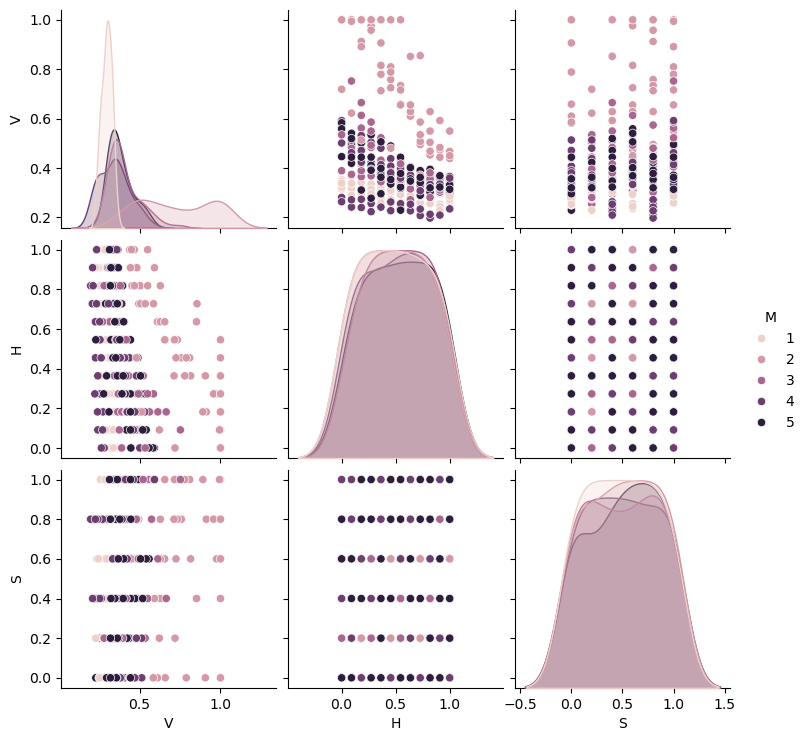

In [39]:
# WRITE SOLUTION HERE

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df, hue='M')
plt.show()

From the scatter plot you can see that the data for the Soil (S) and Height (H) features are 'quantized', i.e., they only take a small number of values. The Soil feature can have one of six possible values, (0.0, 0.2, ..., 1.0); The Height feature can have on of 12 possible values. All the features have been normalized to lie in the range [0,1].

## Step 3 - Generating a training and testing set

We will now split the data into training and test sets. We will use 75% of the data for training and 25% for testing. We will do this using the `train_test_split` function from the `sklearn.model_selection` module. 

First of all, we will need to separate the features (columns 'V', 'H' and 'S') and the labels (column 'M') into separate DataFrames. We can do this using the `drop` method of the `DataFrame` object. The `drop` method takes a list of column names as its first argument and returns a new `DataFrame` object with the specified columns removed. The `drop` method does not modify the original `DataFrame` object.

Store the features in a variable called `mine_data` and the labels as `mine_labels`. Then use `train_test_split` to make the split. Set the train_test_split `random_state` parameter to 1. This will ensure that the data is split in the same way each time the code is run. Store the results of the split in variables `X_train`, `X_test` (for the data) and `y_train`, `y_test` (for the labels).

Write the code in the cell below and then check your code by running the test cell.

In [42]:
# WRITE SOLUTION HERE
from sklearn.model_selection import train_test_split

# Assume df is your DataFrame, and 'target_column' is the column you want to predict
X = df.drop(columns=['M'])  # Features (replace 'target_column' with your actual target column name)
y = df['M']                 # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


In [43]:
# TEST
assert X_train.shape == (253,3)
assert X_test.shape == (85, 3)
assert y_train.shape == (253,)
assert y_test.shape == (85,)
assert X_train.iloc[0].V == 0.480361964603055
assert y_train.iloc[0] == 3

print('All tests passed!')

All tests passed!


## Step 4 - Training a classifier

We will now use a k-Nearest Neighbours classifier to classify the data. We will use the `KNeighborsClassifier` class from the `sklearn.neighbors` library. Initially use a value of k=1.

In the cell below, create a `KNeighborsClassifier` object and assign it to a variable called `model` and then call the fit function with the training data defined above.


In [44]:
# WRITE SOLUTION HERE
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [45]:
assert model.get_params()['n_neighbors'] == 1
assert model._fit_X.shape == (253, 3)
print('All tests passed!')

All tests passed!


## Step 5 - Evaluate the model

We will now use the model's `predict` method to predict the labels for the test data. Assign the predicted labels to a variable called `y_pred`. And then use the `metrics.accuracy_score` function to calculate the accuracy of the model. Store the accuracy in a variable called `score` and print the value to the screen.

Write the code in the cell below.

In [48]:
# WRITE SOLUTION HERE
from sklearn import metrics
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
score = metrics.accuracy_score(y_test, y_pred)

0.29411764705882354


In [49]:
# TEST

assert score == 0.29411764705882354
print('All tests passed!')

All tests passed!


The accuracy is very low, around 0.29, i.e., 29%. Given there are 5 classes we would expect to get around 20% accuracy by chance. The classifier is doing better than chance but it is still getting more classifications wrong than right.

We will try to improve the score in the next step.

## Step 6 - Tuning the model's hyperparameters

In the previous section, we used a k-NN classifier with a value of $k$ set to 1, i.e., this is just a nearest neighbour classifier. We will now try to improve the accuracy by trying different values of $k$. We will try values of $k$ for all odd values in the range of 1 to 21. 

We can tune $k$ by combining the above steps and placing them inside a for loop which iterates over the values of $k$. Inside the for loop add a print statement to print the value of k and the corresponding accuracy score.

Write the code in the cell below.

In [50]:
# WRITE SOLUTION HERE
from sklearn import metrics

for k in range(1, 21, 2):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(k, metrics.accuracy_score(y_test, y_pred))

1 0.29411764705882354
3 0.36470588235294116
5 0.3764705882352941
7 0.29411764705882354
9 0.32941176470588235
11 0.3176470588235294
13 0.3411764705882353
15 0.3411764705882353
17 0.3411764705882353
19 0.36470588235294116


You should find that the best result comes from using a value of k = 5. This gives an accuracy of around 0.38, i.e., 38%. This is a significant improvement over the previous result.

## Step 7 - Analyzing the model performance

We will now rerun the classifier using k = 5 and then use the `confusion_matrix` function to calculate the confusion matrix. Assign the result to a variable called `cm`.

Then use `ConfusionMatrixDisplay` from `sklearn.metrics` to display the confusion matrix. You can set the `display_labels` parameter so that meaningful labels are displayed, e.g., `display_labels=['None', 'AP Mine', 'AT Mine', 'Booby', 'M14']`

Refer to the module lecture notes if you are unsure how to compute and display confusion matrices.

Write the code in the cell below.

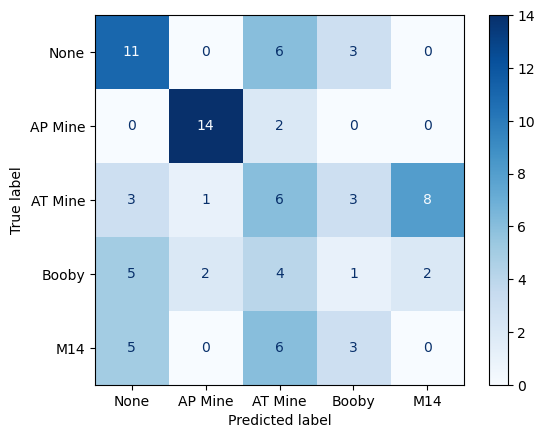

In [56]:
# WRITE SOLUTION HERE
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

# Step 2: Display the confusion matrix with labels
labels = ['None', 'AP Mine', 'AT Mine', 'Booby', 'M14']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#disp.plot(cmap='Blues')  # You can set the color map for aesthetics


disp.plot(cmap='Blues')  # You can set the color map for aesthetics


In [58]:
# TEST
assert cm.shape == (5, 5)
assert cm[0, 0] == 11
print('All tests passed!')


All tests passed!


Examine the confusion matrix. You should see that there are a lot of correct classifications (i.e., numbers on the diagonal). However, there are also some cells off the diagonal which have high values. For example, the classifier is confuses AT mines and M14 mines. More worryingly, the M14 and Booby-trapped AT mine classes are often classified as 'None'. This is a serious problem as it means that the classifier is failing to detect these mines. (In the context of `detection` this is called a `false negative`.) We can also see some false positives, e.g., the classifier is classifying some 'None' samples as AT Mines. 

Consider a real-world application of this classifier. Which type of error would be more consequential? If the classifier was used to detect landmines in a field, false positives would cause the field to be unnecessarily cleared. This would be expensive and time consuming. However, the false negatives are much more serious. If the classifier fails to detect a mine, it could result in the loss of life.


## Step 8 - Evaluate the model using cross-validation

In the previous evaluation, we used 75% of the data for training and just 25% for testing. This meant that the test set was quite small and so the accuracy score and the values in the confusion matrix might not be very reliable.

We will now use the leave-one-out training/test paradigm to evaluate the 5-nearest neighbour classifier more reliably.

To do this, you will need to use the `cross_val_predict` method and the `LeaveOneOut` class from `sklearn.model_selection`. 

Run the leave-one-out cross-validation and then calculate the accuracy score and the confusion matrix. Display the confusion matrix using the `ConfusionMatrixDisplay` class. Also compute the accuracy (stored it in a variable called `accuracy`) and print it.

An example of how to use these can be found in the tutorial notebook. Please reread it if you are not sure.

Write the code in the cell below.

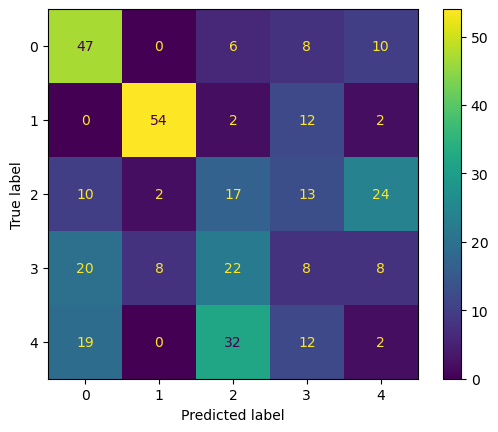

In [66]:
# WRITE SOLUTION HERE
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

model = KNeighborsClassifier(n_neighbors=5)
cv = LeaveOneOut()
y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
cm = metrics.confusion_matrix(y, y_pred)
accuracy = metrics.accuracy_score(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [64]:
# TEST

assert cm.shape == (5, 5)
assert accuracy == 0.378698224852071
print('All tests passed!')

All tests passed!


You should see that the classifier is now making a significant number of false negative type errors, i.e. many of the mines are being classified as 'None'. 

Consider the task as a basic two-class detection problem, i.e. with outputs 'Mine' or 'None', i.e. grouping all the mine classes into a single class. What is the accuracy of the classifier for this task? 

Calculate this by summing values from the confusion matrix.

Write Python code to compute this accuracy in the cell below. Store it in a variable called `detection_accuracy.`



In [105]:
# WRITE SOLUTION HERE

# Step 1: Recode the target to a two-class problem ('Mine' or 'None')
# use cm to calculate

class_none = cm[0]
class_mine = cm[1:4]

# Sum the True Positives and True Negatives
pred_none = class_none.sum()  # 'None' correctly classified as 'None'
pred_mine = class_mine.sum() # 'Mine' correctly classified as 'Mine'
print(pred_none)
print(pred_mine)

all = pred_mine+pred_none

print(pred_mine / pred_mine+pred_none)


# Sum the True Positives and True Negatives
true_negatives = cm[0]  # 'None' correctly classified as 'None'
true_positives = cm[1:4]  # 'Mine' correctly classified as 'Mine'

# Calculate the accuracy from confusion matrix
accuracy = (true_positives + true_negatives) / cm.sum()
print(accuracy.sum())

71
202
72.0
1.227810650887574


In [ ]:
# TEST
assert detection_accuracy == 0.7840236686390533
print('All tests passed!')

We should have found that the accuracy is about 78%.

We can also work out the 'false negative rate', i.e. the percentage of detections where a land mine is missed. We want this to be very low.

This is computed by summing the errors in the first column of the confusion matrix and dividing by the total number of detections.

In [70]:
false_negatives = cm[1:, 0].sum()
print('False negative rate = ', false_negatives / cm.sum() * 100, '%')

False negative rate =  14.497041420118343 %


The value is about 15%. This is far too high for a real-world application.



## Step 9: Retraining the model using two classes

If we are interested in making a two-class detection system, then we can retrain the classifier using just the 'None' and 'Mine' classes. The easiest way to do this is simply to make a new version of `mine_labels` in which all the mine class labels (i.e., 2, 3, 4 and 5) are replaced with a single label, 2. i.e., the new `mine_labels` variable will only contain the values 1 and 2. 

Once we have done this we can simply repeat the LeaveOneOut cross-validation that we used in the previous section and compute the new accuracy and the new (2 class) confusion matrix.

Do this in the cell below.

In [ ]:
# WRITE SOLUTION HERE

When I try this, I find that the performance actually gets a bit poorer, i.e., about 75.1% accuracy compared with 78.4% in the previous section. This is counter-intuitive because we have taken a more direct approach to the problem (i.e., learning just the mine vs non-mine classes) and so would expect to get a better performance. The reason here for this is that we previously tuned the value of $k$ for the 5-class problem. This value of $k$ is not necessarily optimal for the 2-class problem. 

Cut and paste the code above into the cell below and run it with different values of $k$ to see if you can improve the performance.

In [ ]:
# WRITE SOLUTION HERE

After some trial and error I find that the best value of $k$ is 3. This gives an accuracy of 79.6% and a false negative rate of 82.2%. However, 12 of the 267 mines are still being missed. This is probably still too high for a real-world application.

## Summary

In this lab class, you have seen how to use Scikit-Learn to quickly implement a k-nearest neighbour classifier and apply it to a simple classification problem. You have also seen how to use the `cross_val_predict` method to perform leave-one-out cross-validation and how to use the `ConfusionMatrixDisplay` class to display a confusion matrix. 

We have also tuned the value of the hyperparameter $k$ to improve the performance of the classifier. We also saw how the best version of $k$ depended on how we set up the classification problem and that it needed to be retuned for the 2-class problem. Our approach to tuning was rather ad hoc and relied on cutting-and-pasting code. This can easily lead to the introduction of mistakes. Things get even trickier when we use more sophisticated classifiers with a greater number of hyperparameters. Luckily, Scikit-Learn provides a lot of tools to help us deal with this problem. Next week and in the next lab class, we will use these tools to develop a more systematic approach to tuning hyperparameters.